### <span style="color: Green;">CNN </span>

### <span style="color: Blue;">Libraries Imports</span>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from torchsummary import summary
from collections import OrderedDict

### <span style="color: blue;">Dataloader</span>

In [2]:
transform = transforms.Compose([transforms.ToTensor(),\
     transforms.Normalize((0.5,), (0.5,))])
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_data, val_data = random_split(train_data, [50000, 10000])
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


### <span style="color: blue;">MNIST classification using CNN.</span>

In [3]:
class CNNwbn(nn.Module):
    def __init__(self):
        super(CNNwbn, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 7 * 7, 500)
        self.fc2 = nn.Linear(500, 10)
        
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return torch.log_softmax(x, dim=1)

# Model instance
model_no_bn = CNNwbn().to(device)


In [4]:
def train_network(model, train_loader, \
    val_loader, optimizer, criterion, epochs, patience):
    train_loss, val_loss, train_acc, val_acc = [], [], [], []
    best_val_loss = np.inf
    patience_counter = 0
    best_model = None

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0, 0, 0
        train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training")
        
        for data, target in train_loader_tqdm:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = output.max(1)
            correct += predicted.eq(target).sum().item()
            total += target.size(0)
            
            train_loader_tqdm.set_postfix\
                ({'Train Loss': running_loss / (total / train_loader.batch_size)})
        
        train_loss.append(running_loss / len(train_loader))
        train_acc.append(correct / total)

        model.eval()
        running_loss, correct, total = 0, 0, 0
        val_loader_tqdm = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} - Validation")
        
        with torch.no_grad():
            for data, target in val_loader_tqdm:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                running_loss += loss.item()
                _, predicted = output.max(1)
                correct += predicted.eq(target).sum().item()
                total += target.size(0)
                val_loader_tqdm.set_postfix\
                    ({'Val Loss': running_loss / (total / val_loader.batch_size)})

        val_loss_epoch = running_loss / len(val_loader)
        val_loss.append(val_loss_epoch)
        val_acc.append(correct / total)

        if val_loss_epoch < best_val_loss:
            best_val_loss = val_loss_epoch
            patience_counter = 0
            best_model = model.state_dict()  
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f'Early stopping at epoch\
                 {epoch+1}. Best validation loss: {best_val_loss:.4f}')
            model.load_state_dict(best_model)  
            break

    return train_loss, val_loss, train_acc, val_acc, best_model


In [5]:
def test_network(model, test_loader, criterion):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = output.max(1)
            correct += predicted.eq(target).sum().item()
            total += target.size(0)
    return correct / total

In [18]:
optimizer = optim.Adam(model_no_bn.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
epochs = 30
patience = 6

train_loss_no_bn, val_loss_no_bn, train_acc_no_bn, val_acc_no_bn, best_model_no_bn=\
     train_network(model_no_bn, train_loader, val_loader, optimizer, \
        criterion, epochs, patience)

torch.save(best_model_no_bn, 'model_no_bn.pth')

model_no_bn.load_state_dict(best_model_no_bn)

test_acc_no_bn = test_network(model_no_bn, test_loader, criterion)

Epoch 8/30 - Validation: 100%|██████████| 157/157 [00:00<00:00, 158.79it/s, Val Loss=0.0518]


Early stopping at epoch                 8. Best validation loss: 0.0488


In [19]:
class CNNbn(nn.Module):
    def __init__(self):
        super(CNNbn, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 7 * 7, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 32 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return torch.log_softmax(x, dim=1)

model_bn = CNNbn().to(device)


In [20]:
optimizer = optim.Adam(model_no_bn.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
epochs = 30
patience = 6

train_loss_bn, val_loss_bn, train_acc_bn, val_acc_bn, best_model_bn =\
     train_network(model_bn, train_loader, val_loader, optimizer, \
        criterion, epochs, patience)
torch.save(best_model_bn, 'model_bn.pth')

model_bn.load_state_dict(best_model_bn)

test_acc_bn = test_network(model_bn, test_loader, criterion)


Epoch 12/30 - Validation: 100%|██████████| 157/157 [00:01<00:00, 154.11it/s, Val Loss=2.33]


Early stopping at epoch                 12. Best validation loss: 2.3222


In [21]:
def plot_loss_accuracy(train_loss, val_loss, train_acc, val_acc, title):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.title(f'{title} Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Train Acc')
    plt.plot(val_acc, label='Val Acc')
    plt.title(f'{title} Accuracy')
    plt.legend()
    plt.show()

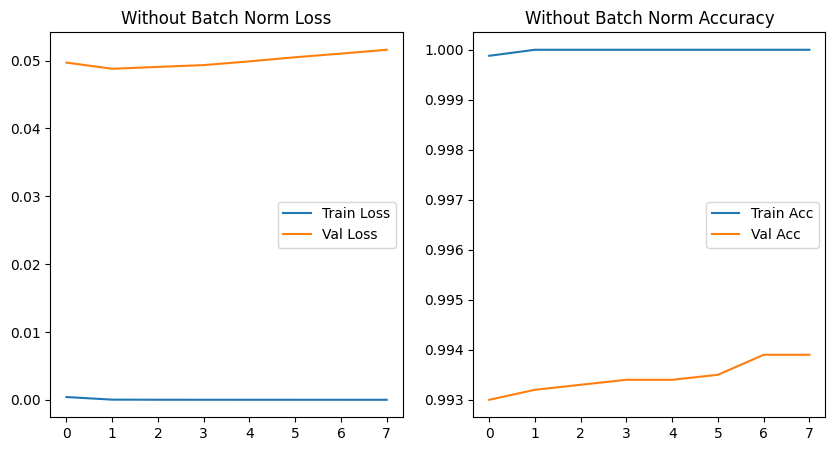

In [22]:
plot_loss_accuracy(train_loss_no_bn, val_loss_no_bn, \
    train_acc_no_bn, val_acc_no_bn, 'Without Batch Norm')

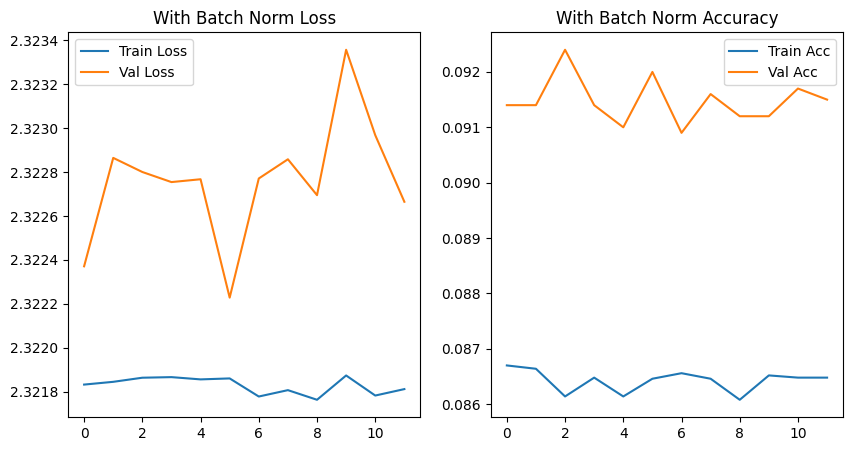

In [23]:
plot_loss_accuracy(train_loss_bn, val_loss_bn,\
    train_acc_bn, val_acc_bn, 'With Batch Norm') # normaize it /255

In [24]:
def plot_random_predictions(model, test_loader):
    model.eval()
    data, target = next(iter(test_loader))
    data, target = data.to(device), target.to(device)
    
    with torch.no_grad():
        output = model(data)
        _, predicted = output.max(1)

    fig = plt.figure(figsize=(12, 6))
    for idx in range(10):
        ax = fig.add_subplot(2, 5, idx+1)
        ax.imshow(data[idx].cpu().squeeze(), cmap='gray')
        ax.set_title(f'True: {target[idx].item()}, Pred: {predicted[idx].item()}')
        ax.axis('off')
    plt.show()

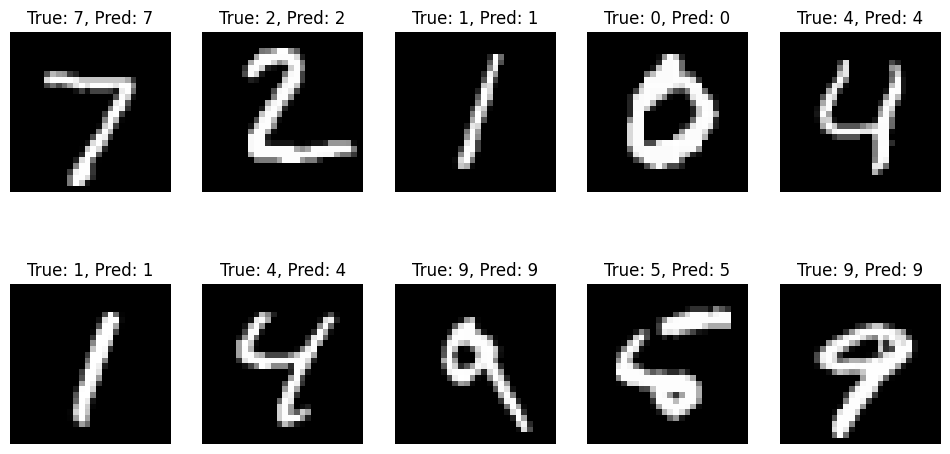

In [25]:

plot_random_predictions(model_no_bn, test_loader)

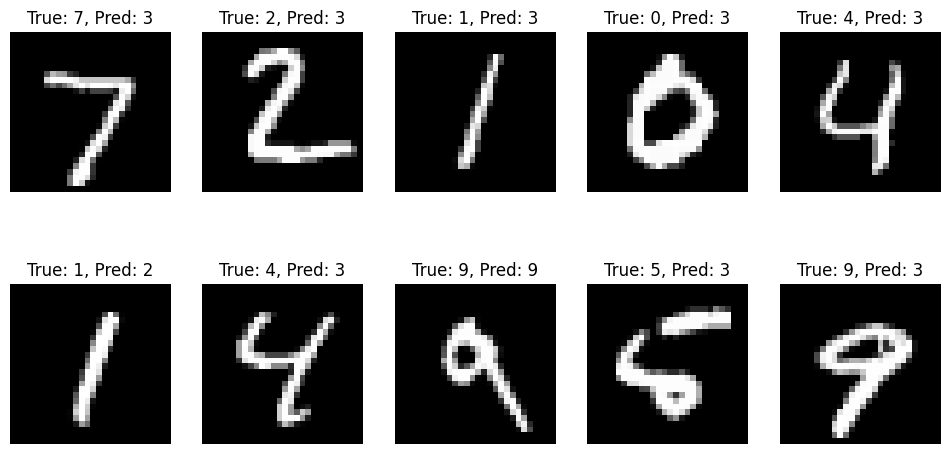

In [26]:

plot_random_predictions(model_bn, test_loader)

In [27]:
summary(model_no_bn, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
            Conv2d-3           [-1, 32, 14, 14]           9,248
         MaxPool2d-4             [-1, 32, 7, 7]               0
            Linear-5                  [-1, 500]         784,500
            Linear-6                   [-1, 10]           5,010
Total params: 799,078
Trainable params: 799,078
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.30
Params size (MB): 3.05
Estimated Total Size (MB): 3.35
----------------------------------------------------------------


In [28]:
summary(model_bn, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           9,248
       BatchNorm2d-5           [-1, 32, 14, 14]              64
         MaxPool2d-6             [-1, 32, 7, 7]               0
            Linear-7                  [-1, 500]         784,500
            Linear-8                   [-1, 10]           5,010
Total params: 799,206
Trainable params: 799,206
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.54
Params size (MB): 3.05
Estimated Total Size (MB): 3.59
----------------------------------------------------------------


### <span style="color: blue;">Visualizing Convolutional Neural Network</span>

In [29]:
def show_layer_filters(model, layer_name, title):
    filters = model.state_dict()[layer_name].cpu().numpy()
    num_filters = filters.shape[0]
    
    plt.figure(figsize=(12, 8))
    for i in range(num_filters):
        ax = plt.subplot(4, 8, i + 1)
        ax.imshow(filters[i, 0, :, :], cmap='gray')
        ax.axis('off')
    plt.suptitle(title)
    plt.show()

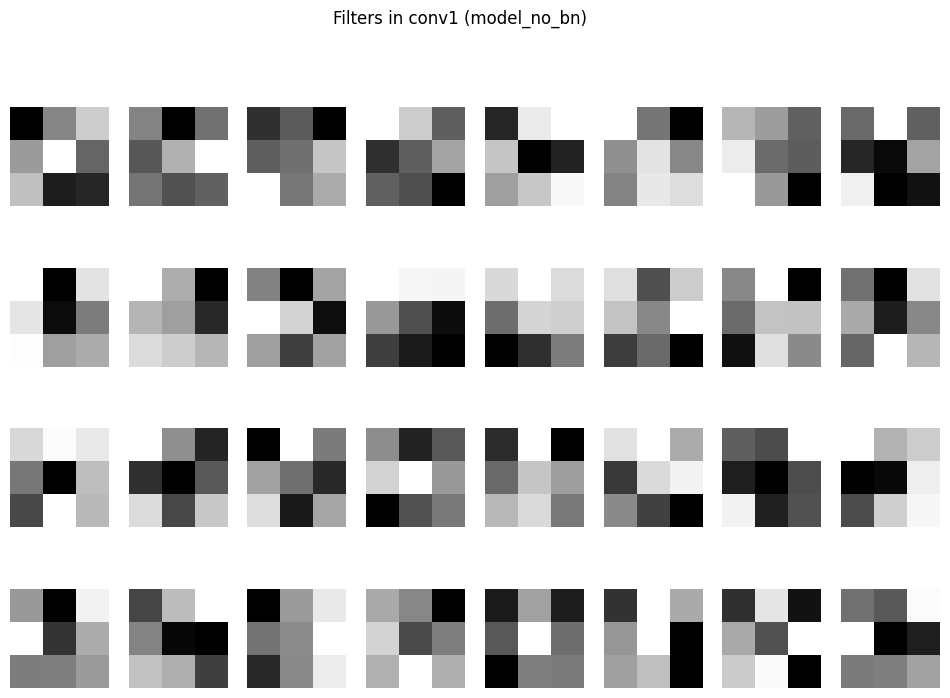

In [30]:
show_layer_filters(model_no_bn, 'conv1.weight', "Filters in conv1 (model_no_bn)")

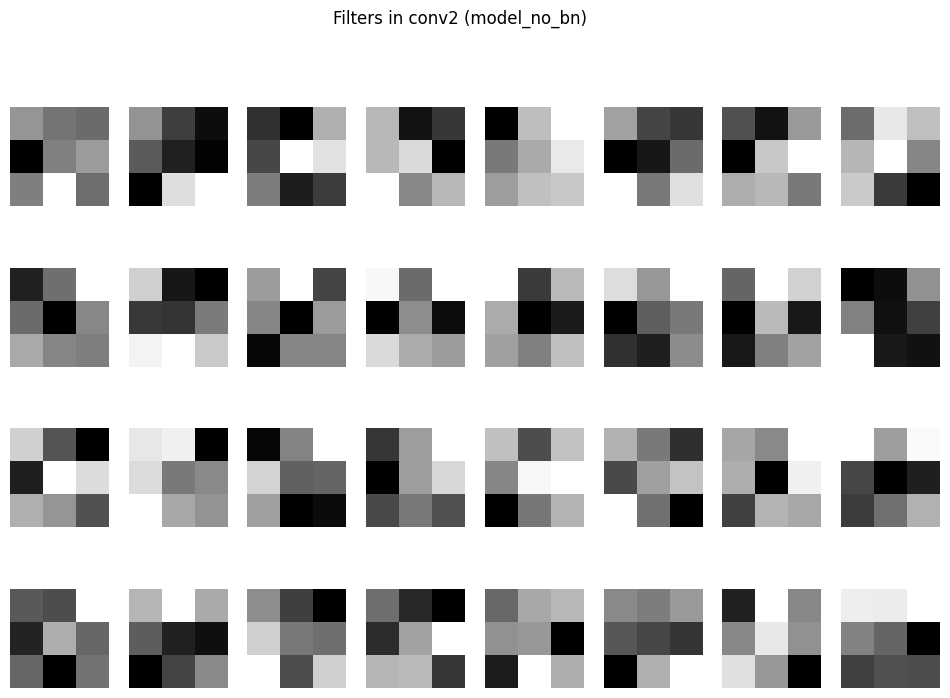

In [31]:
show_layer_filters(model_no_bn, 'conv2.weight', "Filters in conv2 (model_no_bn)")


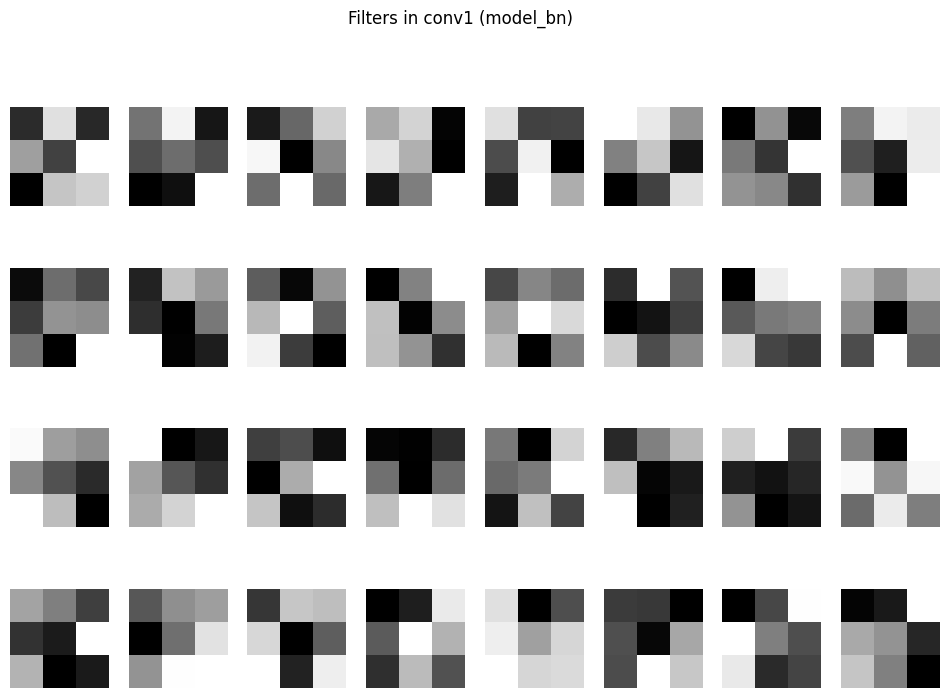

In [32]:
show_layer_filters(model_bn, 'conv1.weight', "Filters in conv1 (model_bn)")

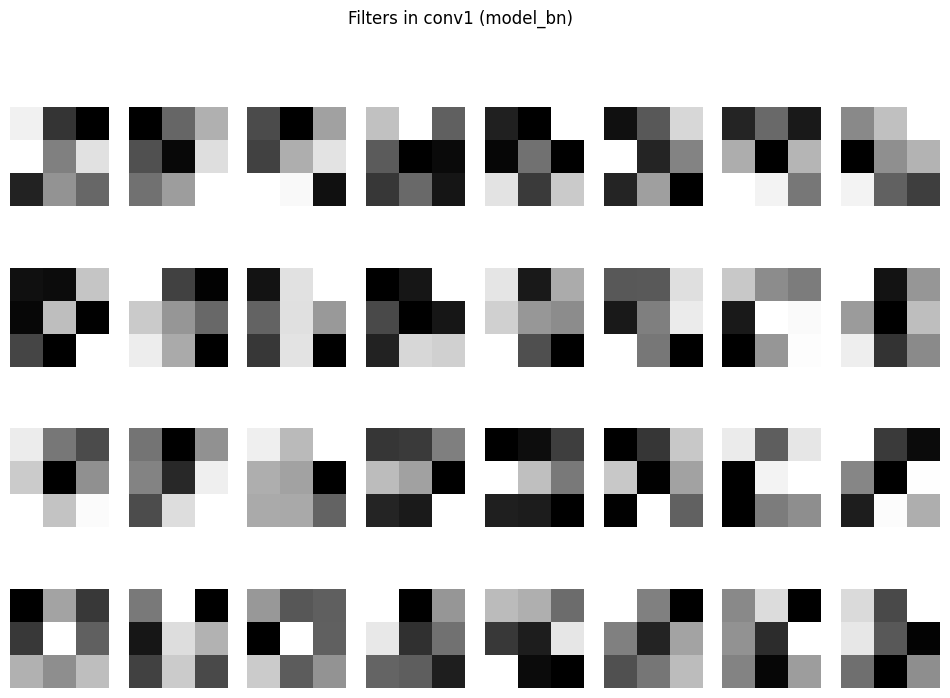

In [33]:
show_layer_filters(model_bn, 'conv2.weight', "Filters in conv1 (model_bn)")

In [34]:

activations_dict = OrderedDict()

def get_activation_hook(name):
    def hook(module, input, output):
        activations_dict[name] = output.detach()
    return hook

def plot_activation(activation, title, num_filters=6):
    act = activation.squeeze().cpu().numpy() 
    fig, axes = plt.subplots(1, num_filters, figsize=(15, 5))
    
    for i in range(num_filters):
        axes[i].imshow(act[i], cmap='gray')
        axes[i].axis('off')
    
    plt.suptitle(title)
    plt.show()

In [35]:
sample_data, _ = next(iter(test_loader))
sample_data = sample_data[0].unsqueeze(0).to(device) 

In [36]:
model_no_bn.conv1.register_forward_hook(get_activation_hook('conv1'))
model_no_bn.conv2.register_forward_hook(get_activation_hook('conv2'))


In [37]:
model_no_bn(sample_data)
print(activations_dict.keys())

odict_keys(['conv1', 'conv2'])


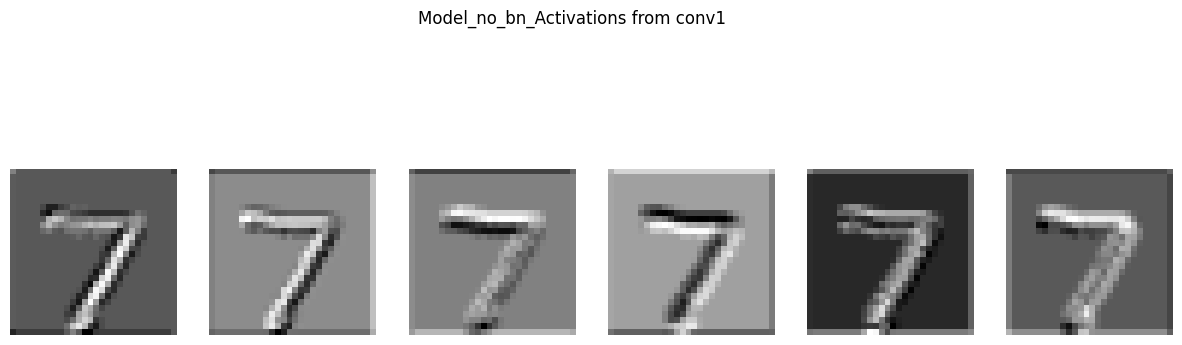

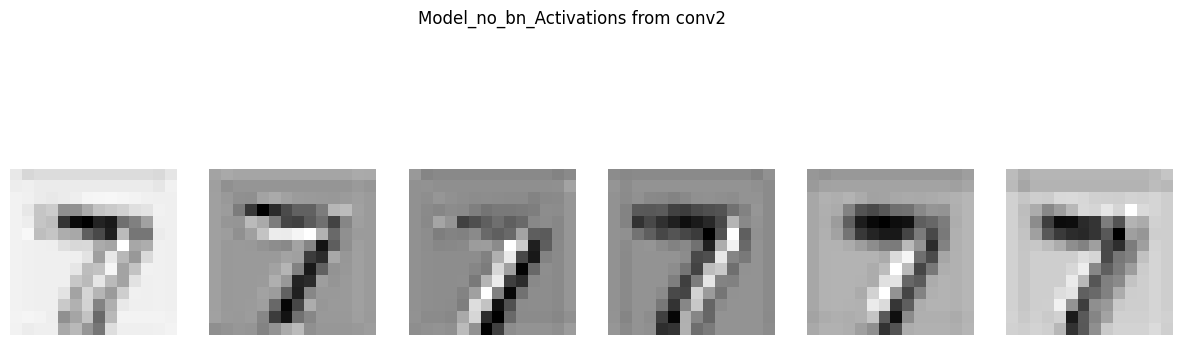

In [38]:
plot_activation(activations_dict['conv1'], "Model_no_bn_Activations from conv1")
plot_activation(activations_dict['conv2'], "Model_no_bn_Activations from conv2")


In [39]:
model_bn.conv1.register_forward_hook(get_activation_hook('conv1'))
model_bn.conv2.register_forward_hook(get_activation_hook('conv2'))


In [40]:
model_bn(sample_data)
print(activations_dict.keys())

odict_keys(['conv1', 'conv2'])


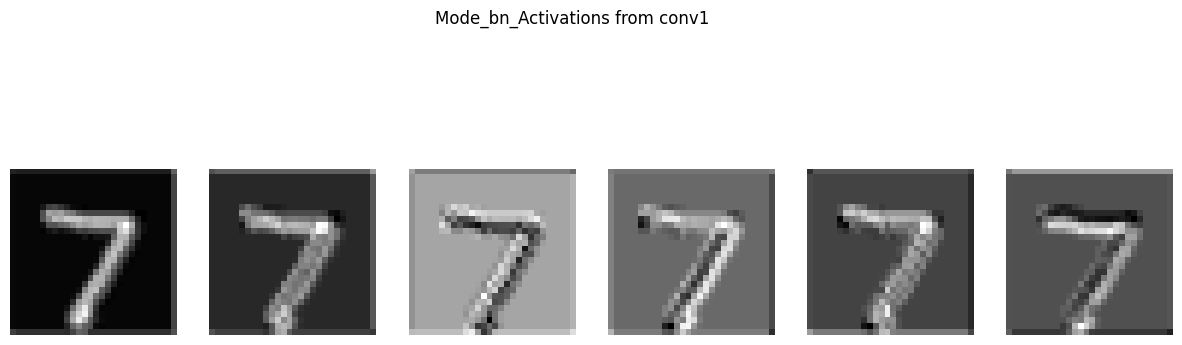

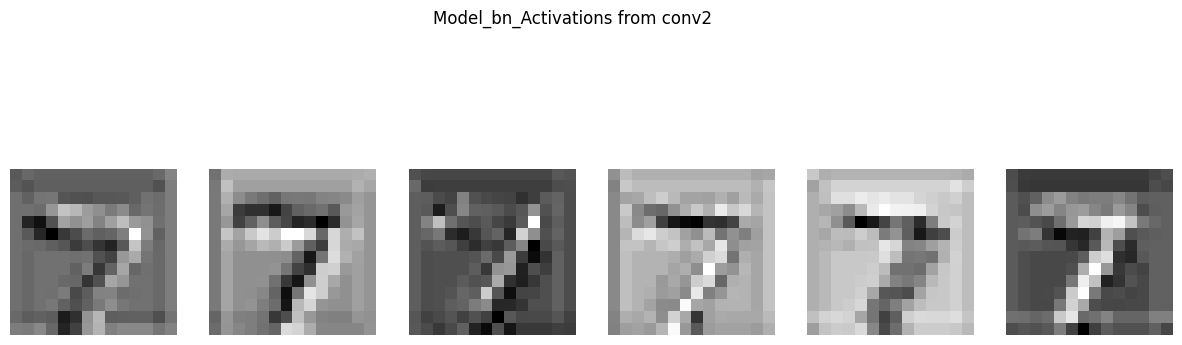

In [41]:
plot_activation(activations_dict['conv1'], "Mode_bn_Activations from conv1")
plot_activation(activations_dict['conv2'], "Model_bn_Activations from conv2")


As we move deeper into the network, the activations tend to become increasingly abstract. The network starts learning more complex patterns by aggregating the low-level features detected in earlier layers. For instance, mid-level layers might detect textures or object parts, while the deepest layers respond to high-level semantic features like entire objects or even complex visual motifs.

In [56]:
def apply_occlusion(image, occlusion_size=2):
    img = image.clone().detach()
    img[:, :, :occlusion_size, :occlusion_size] = 0.2  # Gray_patch
    return img

def occlusion_experiment(model, image, target_class, occlusion_size=5):
    h, w = image.shape[2], image.shape[3]
    probs = np.zeros((h - occlusion_size + 1, w - occlusion_size + 1))
    
    for i in range(h - occlusion_size + 1):
        for j in range(w - occlusion_size + 1):
            occluded_image = image.clone().detach()
            occluded_image[:, :, i:i+occlusion_size, j:j+occlusion_size] = 0.2
            output = model(occluded_image.to(device))
            prob = torch.softmax(output, dim=1)[0, target_class].item()
            probs[i, j] = prob
    
    plt.imshow(probs, cmap='jet', interpolation='nearest')
    plt.colorbar()
    plt.title(f"Probability map for target class {target_class}\
         (occlusion size {occlusion_size})")
    plt.show()

In [57]:
sample_data, sample_label = next(iter(test_loader))
sample_data = sample_data[0].unsqueeze(0)
target_class = sample_label[0].item()

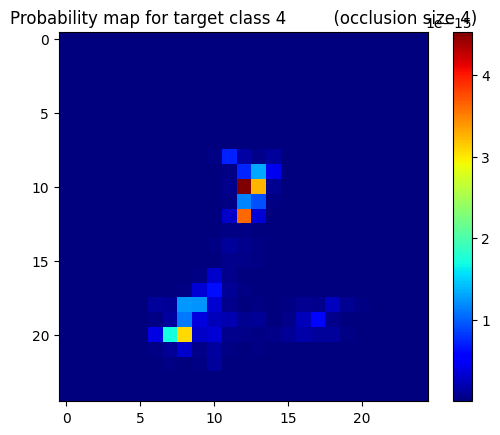

In [58]:
occlusion_experiment(model_no_bn, sample_data, target_class=4, occlusion_size=4)

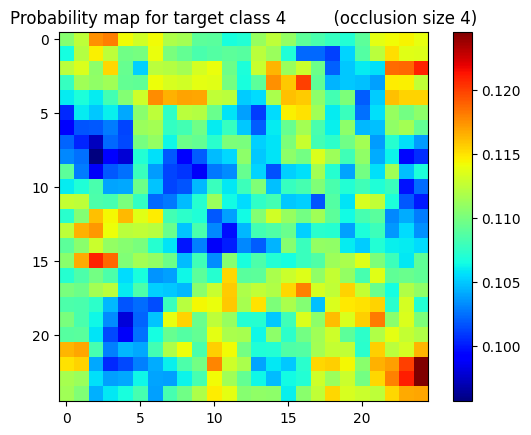

In [59]:
occlusion_experiment(model_bn, sample_data, target_class=4, occlusion_size=4) #check this

### <span style="color: blue;">Adversarial Examples</span>

#### <span style="color: red;">Non-Targeted Attack</span>

In [60]:
model = CNNwbn().to(device)
model.load_state_dict(torch.load('model_no_bn.pth'))
model.eval()

/tmp/ipykernel_4159/3523625898.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_no_bn.pth'))


CNNwbn(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [92]:
def noise_attack_image(image_shape=(1, 28, 28), mean=0.5, std=0.1):
    return torch.randn(image_shape).to(device) * std + mean

def adversarial_generator_non_targeted(model, original_class, image_size=(1, 28, 28),\
     steps=10000, step_size=0.001):
    X = noise_attack_image(image_size)
    X.requires_grad = True
    cost_values = []

    for _ in range(steps):
        output = model(X)
        logits = output[0, original_class]
        cost = logits  
        model.zero_grad()
        cost.backward()

        with torch.no_grad():
            X = X + step_size * X.grad.sign() 
            X = torch.clamp(X, 0, 1) 

        X.requires_grad_(True)  
        cost_values.append(cost.item())

    return X.detach(), cost_values
 

In [93]:
def visualize_generated_images(model, num_classes=10, steps=10000, step_size=0.001):
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    axes = axes.flatten()

    for i in range(num_classes):
        adversarial_img, _ = adversarial_generator_non_targeted(model, i, steps=steps, step_size=step_size)
        adversarial_img_np = adversarial_img.cpu().detach().squeeze().numpy()

        axes[i].imshow(adversarial_img_np, cmap='gray')
        axes[i].set_title(f"Class {i}")
        axes[i].axis('off')

    plt.suptitle("Generated Adversarial Images for Each Class")
    plt.show()

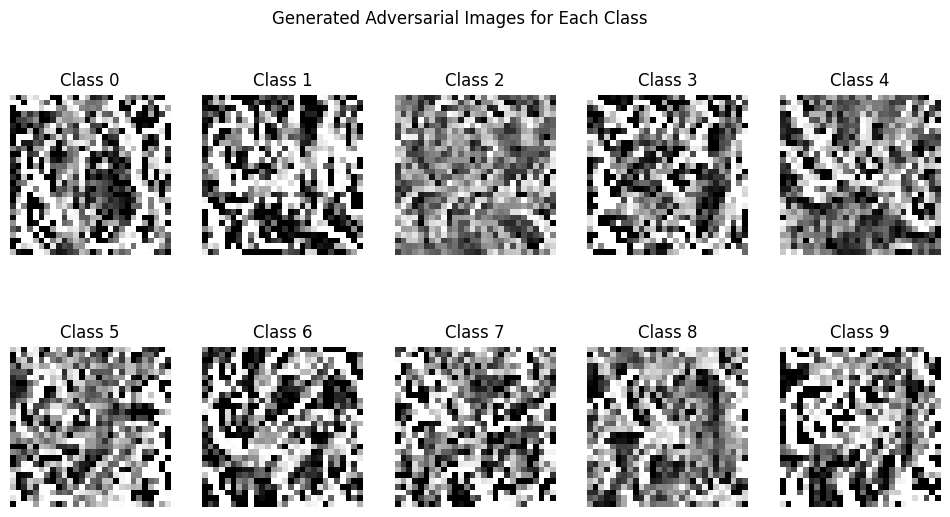

In [94]:
visualize_generated_images(model)

In [95]:
def check_prediction_confidence(model, target_class, adversarial_img):
    with torch.no_grad():
        print(f"Adversarial Image Range: min={adversarial_img.min()}, max={adversarial_img.max()}")
        output = model(adversarial_img.unsqueeze(0).to(device))
        print(f"Logits for Original Class {target_class}: {output}")
        probabilities = torch.softmax(output, dim=1)
        predicted_class = probabilities.argmax(dim=1).item()
        confidence = probabilities[0, target_class].item()
        print(f"Predicted Probabilities: {probabilities}")
        return predicted_class, confidence

def assess_generated_images(model, num_classes=10, steps=10000, step_size=0.001):
    for i in range(num_classes):
        adversarial_img, _ = adversarial_generator_non_targeted(model, i, steps=steps, step_size=step_size)
        predicted_class, confidence = check_prediction_confidence(model, i, adversarial_img)
        print(f"Original Class: {i}, Predicted Class: {predicted_class}, Confidence: {confidence:.4f}")


In [96]:
assess_generated_images(model)

Adversarial Image Range: min=0.0, max=1.0
Logits for Original Class 0: tensor([[   0.0000,  -87.4162,  -86.4768,  -88.7914, -118.9317,  -87.3264,
          -86.3196,  -86.3998,  -87.5683,  -86.6529]], device='cuda:0')
Predicted Probabilities: tensor([[1.0000e+00, 1.0855e-38, 2.7771e-38, 2.7441e-39, 0.0000e+00, 1.1875e-38,
         3.2498e-38, 2.9995e-38, 9.3238e-39, 2.3288e-38]], device='cuda:0')
Original Class: 0, Predicted Class: 0, Confidence: 1.0000
Adversarial Image Range: min=0.0, max=1.0
Logits for Original Class 1: tensor([[-87.8096,   0.0000, -86.9193, -88.3872, -88.2910, -86.7665, -86.6322,
         -86.7415, -88.3808, -88.0386]], device='cuda:0')
Predicted Probabilities: tensor([[7.3242e-39, 1.0000e+00, 1.7841e-38, 4.1107e-39, 4.5259e-39, 2.0787e-38,
         2.3776e-38, 2.1313e-38, 4.1372e-39, 5.8251e-39]], device='cuda:0')
Original Class: 1, Predicted Class: 1, Confidence: 1.0000
Adversarial Image Range: min=0.0, max=1.0
Logits for Original Class 2: tensor([[-87.8074, -87.

In [76]:
def analyze_image_appearance(model, num_classes=10, steps=10000, step_size=0.001):
    for i in range(num_classes):
        adversarial_img, _ = adversarial_generator_non_targeted(model, i, steps=steps, step_size=step_size)
        adversarial_img_np = adversarial_img.cpu().detach().squeeze().numpy()
        
        plt.imshow(adversarial_img_np, cmap='gray')
        plt.title(f"Generated Adversarial Image for Class {i}")
        plt.axis('off')
        plt.show()

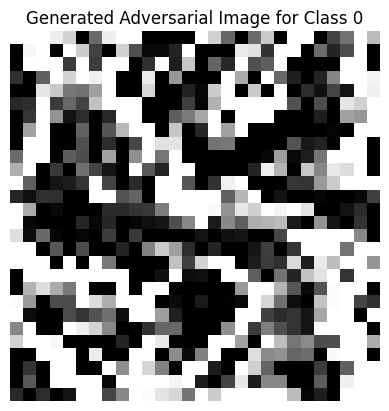

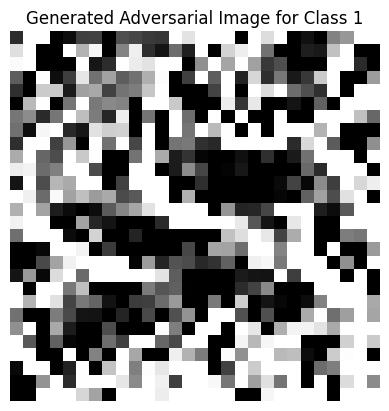

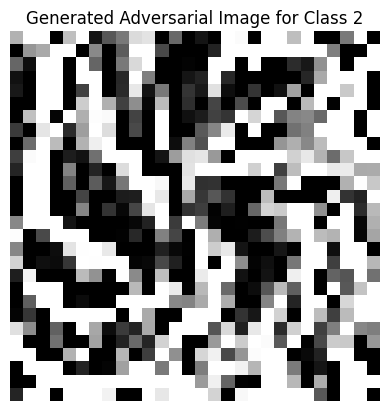

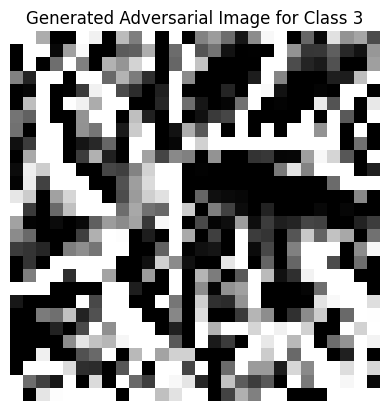

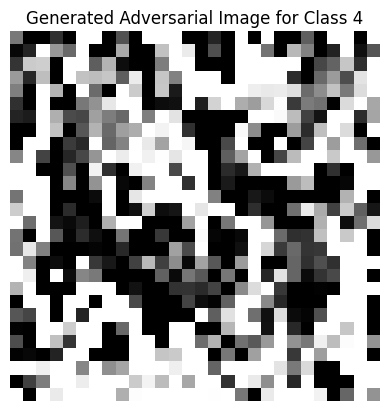

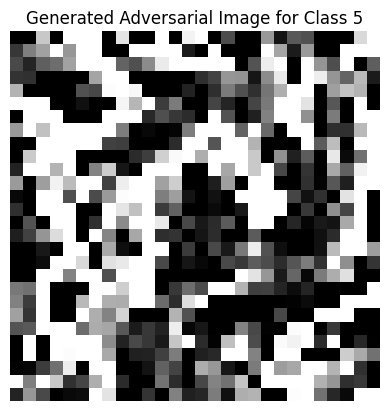

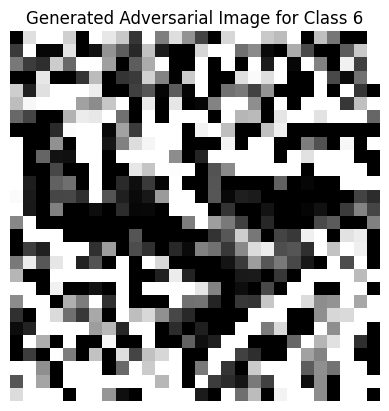

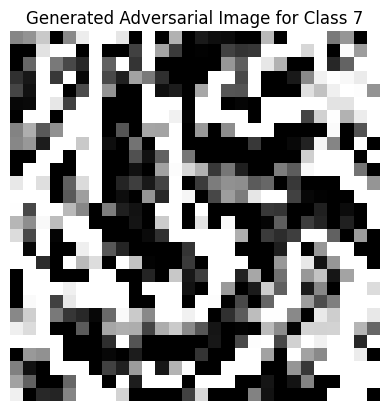

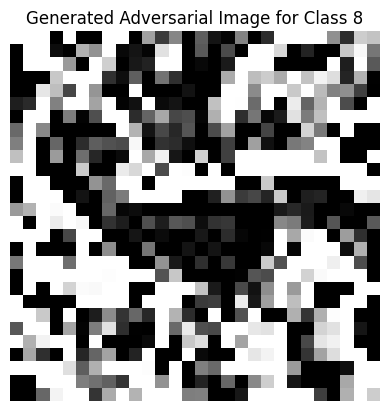

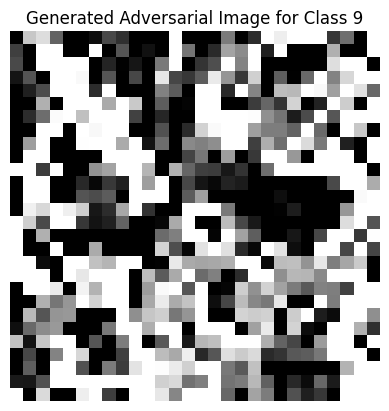

In [77]:
analyze_image_appearance(model)

In [58]:
def plot_cost_function(model, target_class, steps=10000, step_size=0.001):
    _, cost_values = adversarial_generator_non_targeted(model, target_class, steps=steps, step_size=step_size)
    
    plt.plot(range(steps), cost_values)
    plt.title(f"Cost Function Over Time for Class {target_class}")
    plt.xlabel("Step")
    plt.ylabel("Cost (logits)")
    plt.show()

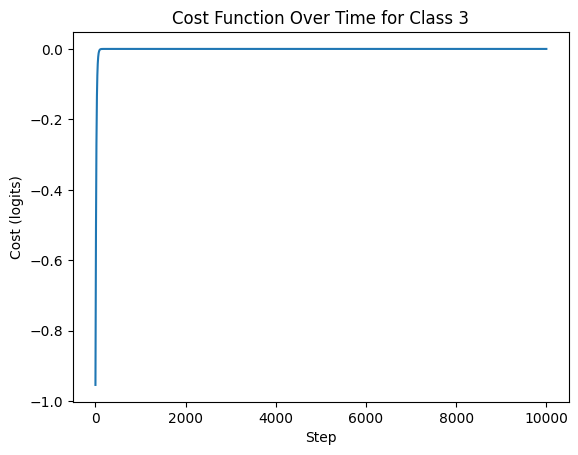

In [59]:
plot_cost_function(model, target_class=3)

#### <span style="color: red;">Targeted Attack</span>

In [60]:
def targeted_adversarial_generator(model, target_class, target_image, \
    image_size=(1, 28, 28), steps=10000, step_size=0.001, beta=0.0001):
    X = noise_attack_image(image_size)
    X.requires_grad = True
    mse_loss = nn.MSELoss()
    cost_values = []

    for _ in range(steps):
        output = model(X)
        logits = output[0, target_class]
        mse = mse_loss(X, target_image)
        cost = logits - beta * mse
        model.zero_grad()
        cost.backward()

        with torch.no_grad():
            X = X + step_size * X.grad.sign()  
            X = torch.clamp(X, 0, 1)  

        X.requires_grad_(True) 
        cost_values.append(cost.item())

    return X.detach(), cost_values


In [61]:
def visualize_targeted_attack(model, original_class=2, target_class=5,\
     steps=10000, step_size=0.001, beta=0.0001):
    sample_data, _ = next(iter(test_loader))
    original_image = sample_data[0].unsqueeze(0).to(device) 
     # Get an image of the original class 

    adversarial_img, _ = targeted_adversarial_generator(model,\
         target_class, original_image, steps=steps, step_size=step_size, beta=beta)
    adversarial_img_np = adversarial_img.cpu().detach().squeeze().numpy()

    plt.imshow(adversarial_img_np, cmap='gray')
    plt.title(f"Original Class: {original_class}, Target Class: {target_class}")
    plt.axis('off')
    plt.show()

/root/miniconda3/envs/pytorch_gpu/lib/python3.8/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1, 1, 28, 28])) that is different to the input size (torch.Size([1, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


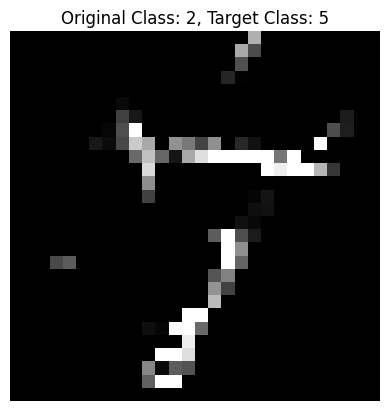

In [62]:
visualize_targeted_attack(model, original_class=2, target_class=5)

In [63]:
def evaluate_targeted_attack(model, adversarial_img, target_class):
    with torch.no_grad():
        output = model(adversarial_img.unsqueeze(0).to(device))
        probabilities = torch.softmax(output, dim=1)
        predicted_class = probabilities.argmax(dim=1).item()
        confidence = probabilities[0, target_class].item()
        return predicted_class, confidence

def test_targeted_attack(model, original_class=2, target_class=5, \
    steps=10000, step_size=0.001, beta=0.0001):
    sample_data, _ = next(iter(test_loader))
    original_image = sample_data[0].unsqueeze(0).to(device) 

    adversarial_img, _ = targeted_adversarial_generator(model, target_class,\
         original_image, steps=steps, step_size=step_size, beta=beta)
    predicted_class, confidence = evaluate_targeted_attack(model, \
        adversarial_img, target_class)

    print(f"Original Class: {original_class}, Predicted Class:\
         {predicted_class}, Confidence: {confidence:.4f}")

In [64]:
test_targeted_attack(model, original_class=2, target_class=5)

Original Class: 2, Predicted Class:         5, Confidence: 1.0000


In [65]:
def analyze_beta_effect(model, original_class=2, target_class=5, steps=10000, step_size=0.001):
    beta_values = [0.00001, 0.0001, 0.001]
    for beta in beta_values:
        print(f"Testing with beta={beta}")
        visualize_targeted_attack(model, original_class, target_class,\
             steps=steps, step_size=step_size, beta=beta)
        test_targeted_attack(model, original_class, target_class, 
        steps=steps, step_size=step_size, beta=beta)

Testing with beta=1e-05


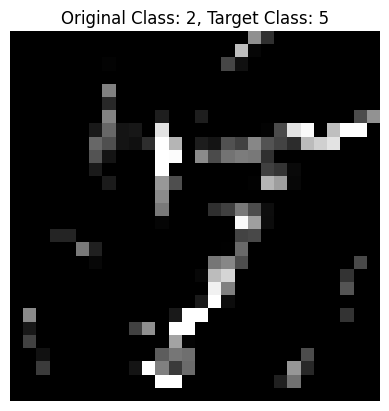

Original Class: 2, Predicted Class:         5, Confidence: 1.0000
Testing with beta=0.0001


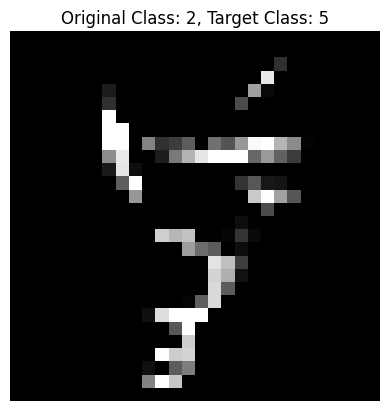

Original Class: 2, Predicted Class:         5, Confidence: 1.0000
Testing with beta=0.001


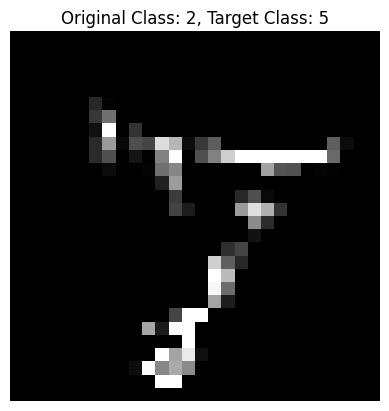

Original Class: 2, Predicted Class:         5, Confidence: 1.0000


In [66]:

analyze_beta_effect(model, original_class=2, target_class=5)